In [1]:
from ucimlrepo import fetch_ucirepo
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler

In [2]:
wine_quality = fetch_ucirepo(id=186)
print(wine_quality.variables)
df = wine_quality.data.original

                    name     role         type demographic  \
0          fixed_acidity  Feature   Continuous        None   
1       volatile_acidity  Feature   Continuous        None   
2            citric_acid  Feature   Continuous        None   
3         residual_sugar  Feature   Continuous        None   
4              chlorides  Feature   Continuous        None   
5    free_sulfur_dioxide  Feature   Continuous        None   
6   total_sulfur_dioxide  Feature   Continuous        None   
7                density  Feature   Continuous        None   
8                     pH  Feature   Continuous        None   
9              sulphates  Feature   Continuous        None   
10               alcohol  Feature   Continuous        None   
11               quality   Target      Integer        None   
12                 color    Other  Categorical        None   

               description units missing_values  
0                     None  None             no  
1                     None  Non

Na osnovu karakteristika vina ($X$) određujemo vrstu ($Y$). Podatke delimo na skupove za trening, validaciju i test, tako da im ostane isti odnos instanci kojese odnose na crno i na belo vino.

Podatke skaliramo na osnovu raspodele podataka u skupu za trening i validaciju.

In [5]:
X = df.iloc[:, :-2]  
y = df['color']

X_train_validation, X_test, y_train_validation, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_validation, y_train_validation, test_size=0.2, random_state=42, stratify=y_train_validation)
#print(X_train_validation.describe(), y_train_validation.describe())

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


Iz podataka možemo uočiti da bela i crna vina nisu jednako zastupljena, kao i distribucije različitih karakteristika vina u zavisnosti od njihove vrste:

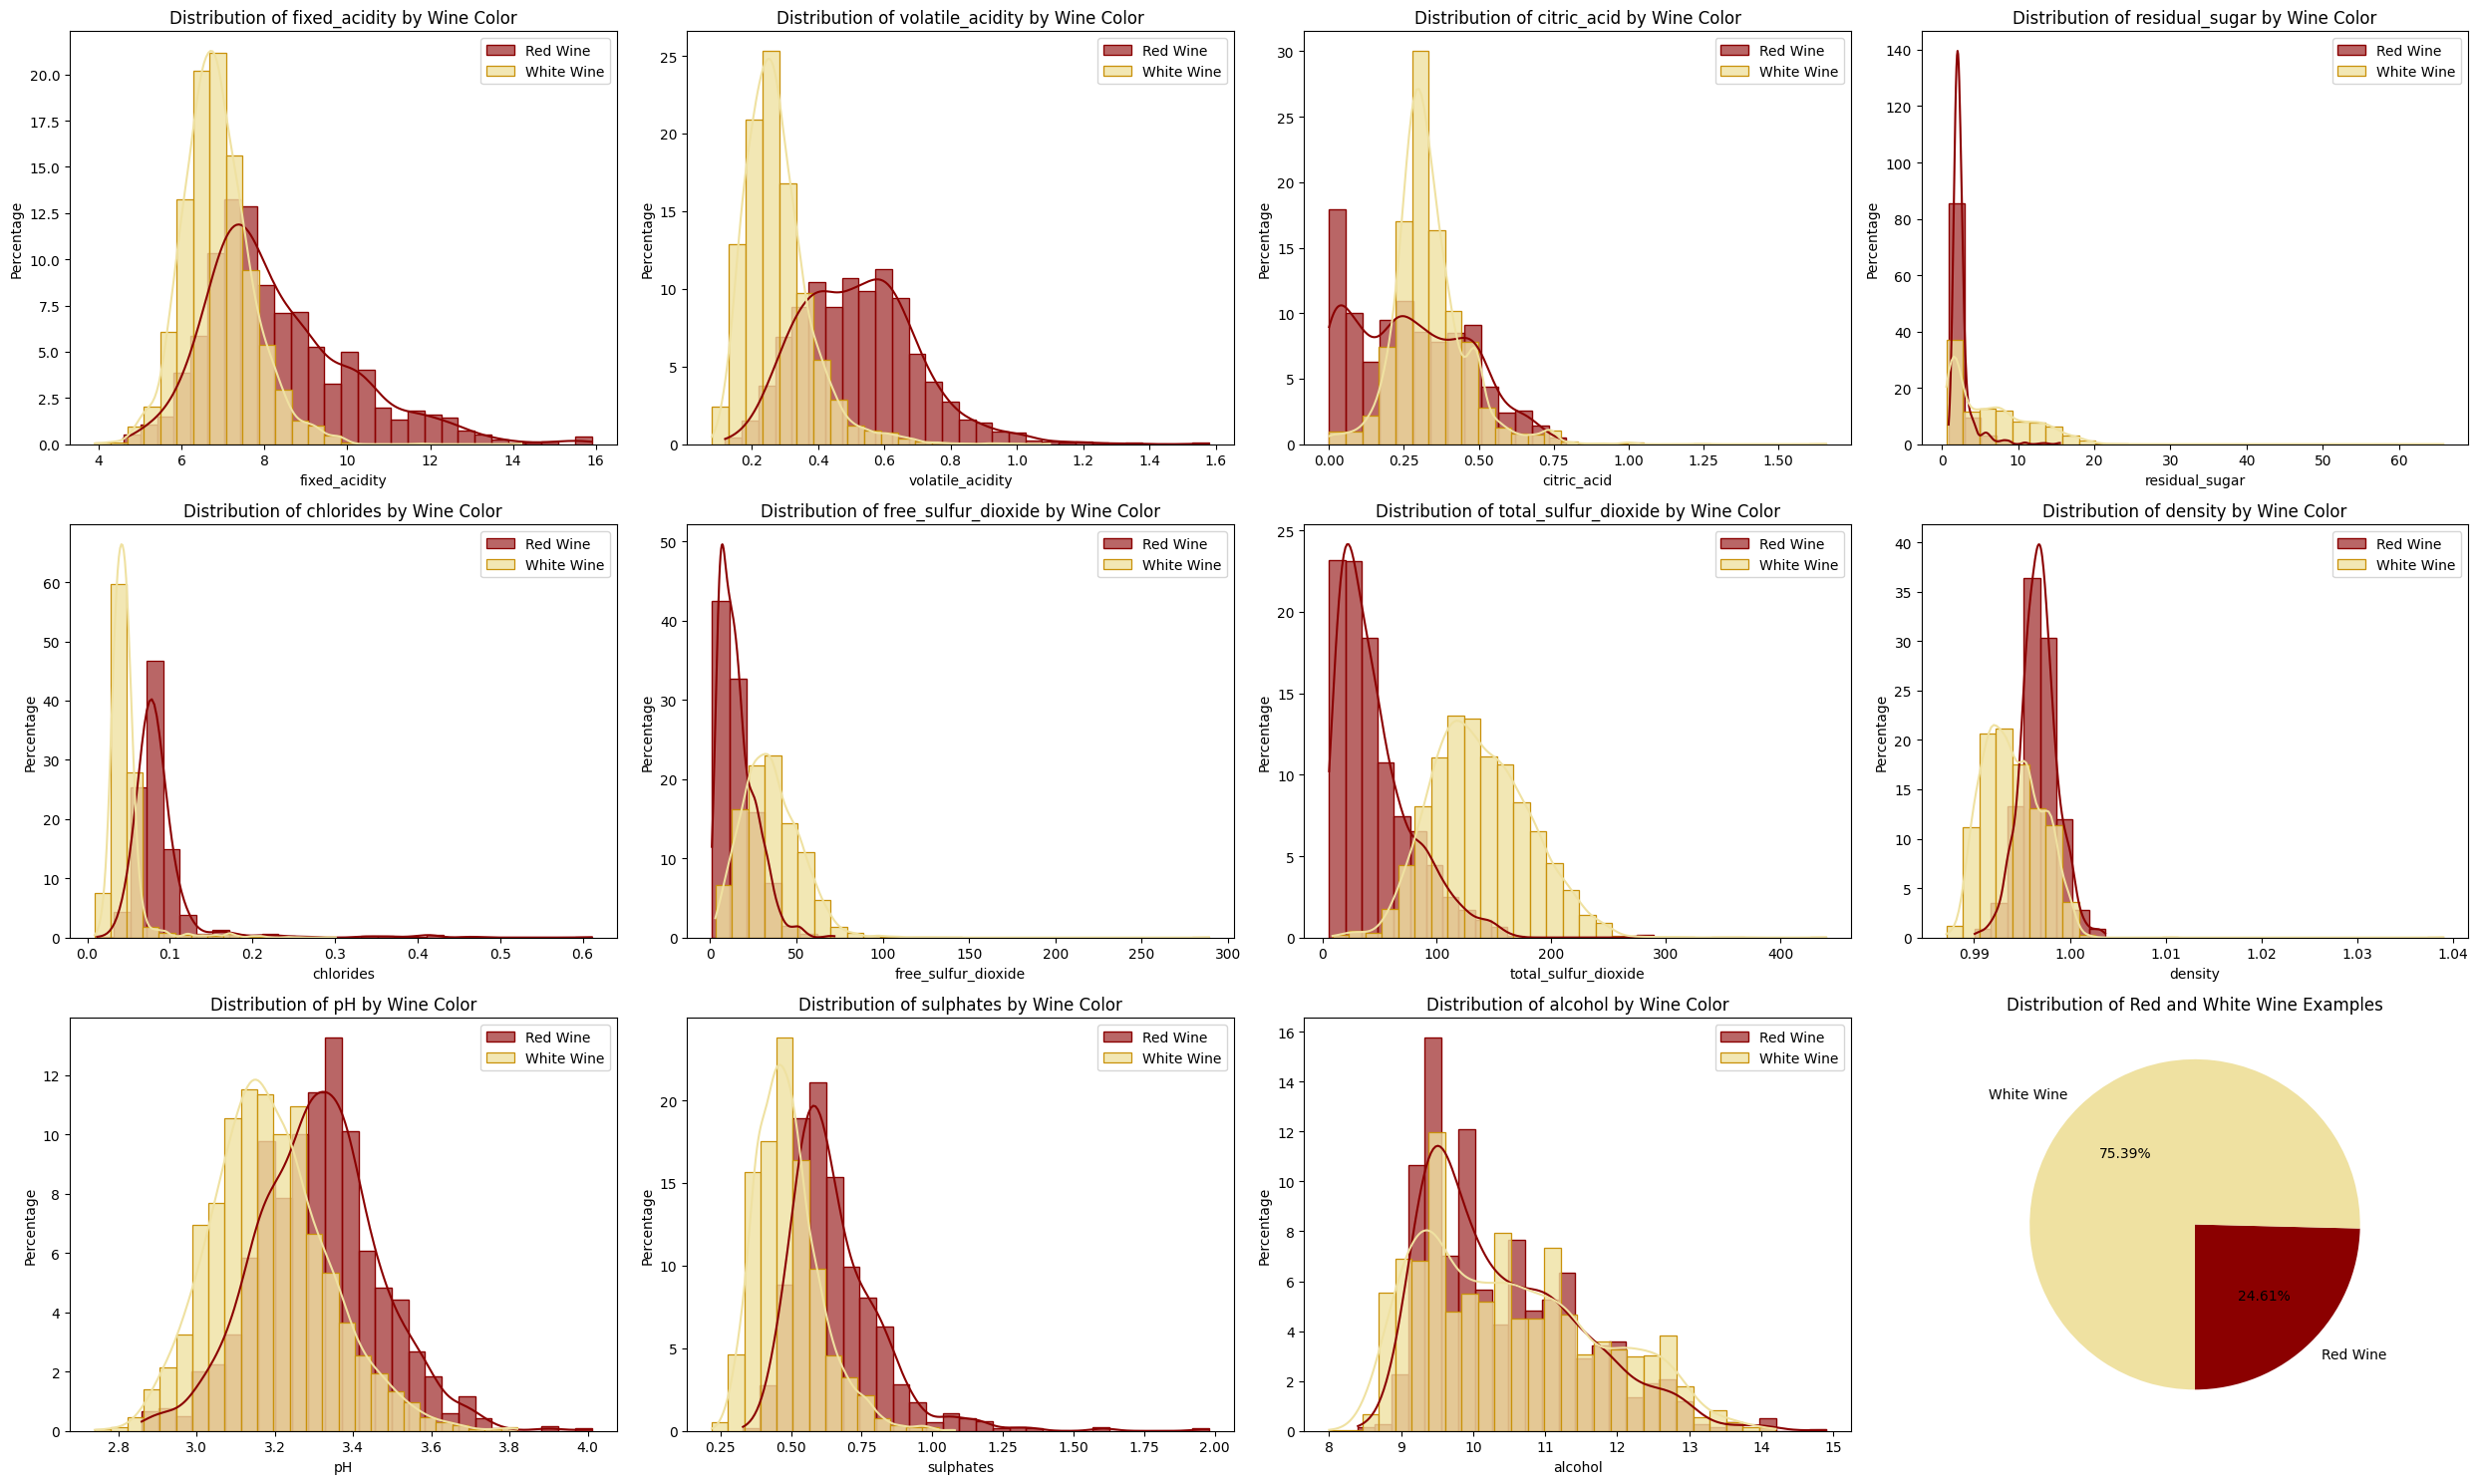

In [6]:
red_wine = X_train_validation[y_train_validation == 'red']
white_wine = X_train_validation[y_train_validation == 'white']

fig, axes = plt.subplots(3, 4, figsize=(25, 15))

axes = axes.flatten()

for i, column in enumerate(X_train_validation.columns):
    ax = axes[i]
    
    combined_min = min(red_wine[column].min(), white_wine[column].min())
    combined_max = max(red_wine[column].max(), white_wine[column].max())
    combined_range = combined_max - combined_min
    binwidth = combined_range / 30

    sb.histplot(red_wine[column], color='darkred', edgecolor='darkred', kde=True, label='Red Wine', alpha=0.6, stat='percent', binwidth=binwidth, ax=ax)
    sb.histplot(white_wine[column], color='#EFE1A1', edgecolor='#C9910A', kde=True, label='White Wine', alpha=0.8, stat='percent', binwidth=binwidth, ax=ax)
    
    ax.set_title(f'Distribution of {column} by Wine Color')
    ax.set_xlabel(column)
    ax.set_ylabel('Percentage')
    ax.legend()


ax_pie = axes[-1]

wine_counts = [len(red_wine), len(white_wine)]
wine_labels = ['Red Wine', 'White Wine']
wine_colors = ['darkred', '#EFE1A1']

ax_pie.pie(wine_counts, labels=wine_labels, colors=wine_colors, autopct='%.2f%%', startangle=-90)
ax_pie.set_title('Distribution of Red and White Wine Examples')

plt.tight_layout()
plt.show()

Vidimo da za pojedine karakteristike, kao što su gustina i slatkoća, veoma razlikuju u zavisnosti od vrste vina, što nam sugeriše da bi jednostavniji model kao što je logistička regresija mogao biti dobar za njihovu klasifikaciju

## Logisticka regresija

In [7]:
def show_report(model_name, model, x_val, y_val):
    y_val_pred = model.predict(x_val)
    report = classification_report(y_val, y_val_pred, target_names=['Red Wine', 'White Wine'], digits=3)
    print(f"Validation Report for {model_name}:\n\n {report}")
    
    cm = confusion_matrix(y_val, y_val_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Red Wine', 'White Wine'])

    cm_display.plot(cmap='GnBu')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()
    
def show_coeffs(model_name,model):
    coefficients = model.coef_[0]
    features = X.columns
    coeff_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
    coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)

    print(f"{model_name} Coefficients: \n\n{coeff_df}\n")

Logistic Regression Coefficients: 

                 Feature  Coefficient
6   total_sulfur_dioxide     3.027041
3         residual_sugar     2.305639
2            citric_acid     0.372261
0          fixed_acidity    -0.174351
8                     pH    -0.272818
9              sulphates    -0.758930
5    free_sulfur_dioxide    -0.898906
4              chlorides    -0.972138
1       volatile_acidity    -1.001928
10               alcohol    -1.564809
7                density    -3.947323

Validation Report for Logistic Regression:

               precision    recall  f1-score   support

    Red Wine      0.987     0.975     0.981       240
  White Wine      0.992     0.996     0.994       735

    accuracy                          0.991       975
   macro avg      0.990     0.985     0.988       975
weighted avg      0.991     0.991     0.991       975



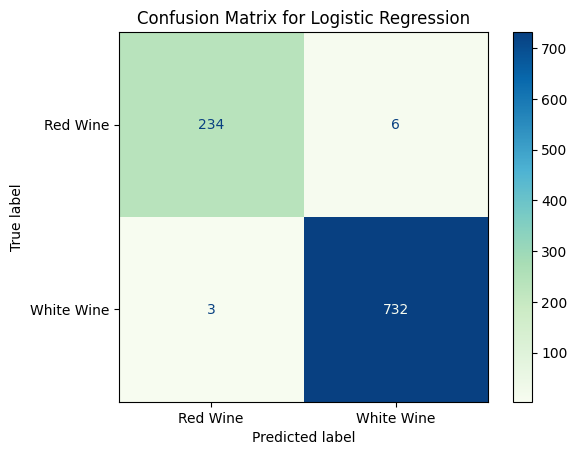

In [8]:
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train_scaled, y_train)

show_coeffs("Logistic Regression", logistic_model)
show_report("Logistic Regression", logistic_model, X_val_scaled, y_val)

Kako znamo da kategorije nisu balansirane, pokušaćemo da popravimo rezultat nasumičnmim ponavljanjem instanci manje reprezentovane klase, koristeći `RandomOverSampler`.

Logistic Regression with ROS Coefficients: 

                 Feature  Coefficient
3         residual_sugar     2.864427
6   total_sulfur_dioxide     2.702436
0          fixed_acidity     0.468190
2            citric_acid     0.320794
8                     pH     0.057998
9              sulphates    -0.537060
5    free_sulfur_dioxide    -0.797006
1       volatile_acidity    -0.900641
4              chlorides    -0.916166
10               alcohol    -2.291327
7                density    -5.051486

Validation Report for Logistic Regression with ROS:

               precision    recall  f1-score   support

    Red Wine      0.979     0.983     0.981       240
  White Wine      0.995     0.993     0.994       735

    accuracy                          0.991       975
   macro avg      0.987     0.988     0.988       975
weighted avg      0.991     0.991     0.991       975



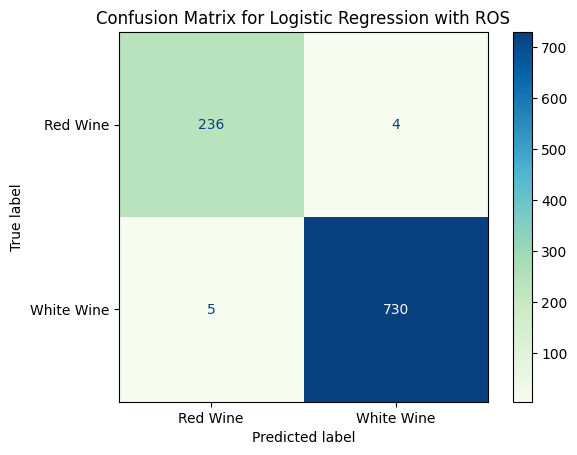

In [9]:
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_scaled, y_train)

logistic_model_ros = LogisticRegression(random_state=42)
logistic_model_ros.fit(X_train_resampled, y_train_resampled)

show_coeffs("Logistic Regression with ROS", logistic_model_ros)
show_report("Logistic Regression with ROS", logistic_model_ros, X_val_scaled, y_val)

Kako su karakteristike normalizovane, iz dobijenih koeficijenata vidimo pozitivnu korelaciju gustine i procenta alkohola sa "crvenosti" vina, kao i korelaciju slatkoće i količine sulfur-dioksida sa belim vinom, što smo i pretpostavil iz grafika raspodela karakteristika. Sa druge strane, pH vrednost ima najmanji apsolutni koeficijent, što je takođe očekivano zbog sličnosti u raspodelama.

Klasifikacija se dodatno može popraviti uvođenjem skrivenog sloja sa 4 čvora:

Validation Report for MLP:

               precision    recall  f1-score   support

    Red Wine      0.987     0.983     0.985       240
  White Wine      0.995     0.996     0.995       735

    accuracy                          0.993       975
   macro avg      0.991     0.990     0.990       975
weighted avg      0.993     0.993     0.993       975



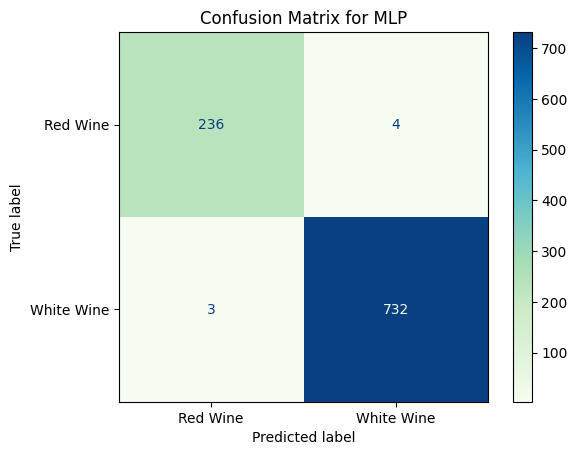

In [10]:
mlp_model = MLPClassifier(hidden_layer_sizes=(4,), random_state=42, max_iter=500)
mlp_model.fit(X_train_resampled, y_train_resampled)

show_report("MLP", mlp_model, X_val_scaled, y_val)

### Gaussian Naive Bayes

**Gaussian Naive Bayes** je klasifikacioni algoritam koji pretpostavlja da su vrednosti svake karakteristike unutar svake klase distribuirane prema normalnoj (Gausovoj) distribuciji, i međusobno nezavisne.

Kako su parametri našeg modela fizičko-hemijske karakteristike, one imaju normalu distribuciju (što smo mogli videti na graficima), ali nisu nezavisne.

#### Metoda:

- **Normalna distribucija**: Za svaku klasu, model izračunava sredinu $\mu_k$ i varijansu $\sigma_k^2$ za svaku karakteristiku. Kada se dobije nova vrednost neke karakteristike, verovatnoća da ta vrednost pripada određenoj klasi računa se pomoću formule za normalnu distribuciju.

- **Izračunavanje verovatnoće**:
  
  Verovatnoća da data vrednost karakteristike $v$ pripada određenoj klasi $C_k$ računa se korišćenjem funkcije gustine verovatnoće za normalnu distribuciju, gde su $\mu_k$ i $\sigma_k^2$ sredina i varijansa te karakteristike unutar klase $C_k$:
  
  $$
  p(x = v \mid C_k) = \frac{1}{\sqrt{2\pi \sigma_k^2}} \, e^{-\frac{(v - \mu_k)^2}{2\sigma_k^2}}
  $$
  
  Ova formula omogućava izračunavanje verovatnoće da određena vrednost $v$ pripada klasi $C_k$, uz pretpostavku da su podaci u toj klasi normalno distribuirani.






Validation Report for GaussianNB:

               precision    recall  f1-score   support

    Red Wine      0.904     0.979     0.940       240
  White Wine      0.993     0.966     0.979       735

    accuracy                          0.969       975
   macro avg      0.948     0.973     0.960       975
weighted avg      0.971     0.969     0.970       975



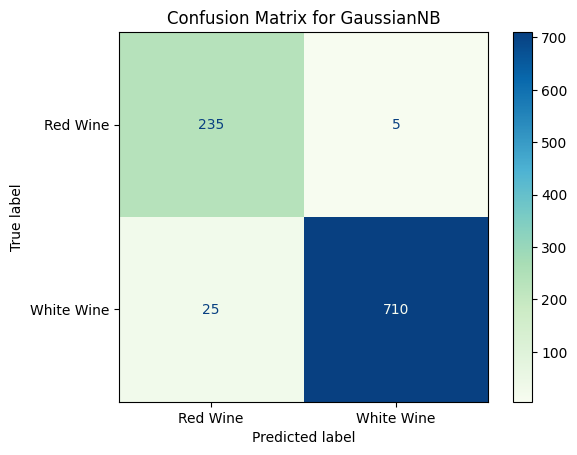

In [11]:
nb_model = GaussianNB()
nb_model.fit(X_train_resampled, y_train_resampled)

show_report("GaussianNB", nb_model, X_val_scaled, y_val)

Lošiji rezultati ove metode mogu se objasniti pogrešnom pretpostavkom da su karakteristike vina međusobno nezavisne.

## Metod potpornih vektora

Zbog vidnih razlika u raspodelama pojedinih karakteristika, možemo očekivati da će podaci biti približno linearno separabilni, zbog čeka je sledeća metoda koju testiramo metod potpornih vektora.

Validation Report for SVM:

               precision    recall  f1-score   support

    Red Wine      0.992     0.983     0.987       240
  White Wine      0.995     0.997     0.996       735

    accuracy                          0.994       975
   macro avg      0.993     0.990     0.992       975
weighted avg      0.994     0.994     0.994       975



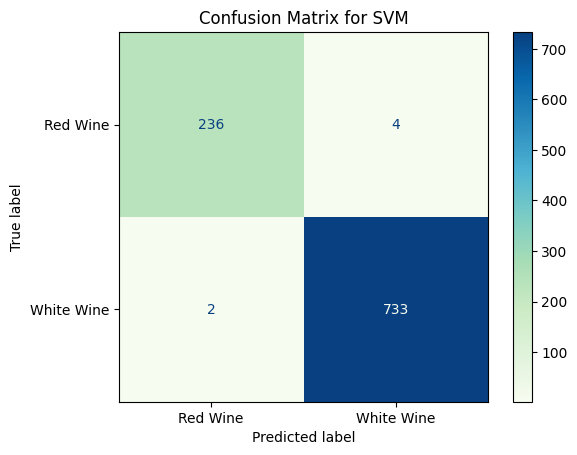

In [12]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_resampled, y_train_resampled)

show_report("SVM", svm_model, X_val_scaled, y_val)

Vidimo da SVM daje slične rezultate kao MLP, uz jednostavniju arhitekturu i intrepretabilnije rezultate. 

***komentar o odnosu LR i SVM koeficijenata***

In [13]:
show_coeffs("SVM", svm_model)
show_coeffs("Logistic Regression", logistic_model_ros)

SVM Coefficients: 

                 Feature  Coefficient
3         residual_sugar     1.634235
6   total_sulfur_dioxide     1.183550
0          fixed_acidity     0.348808
2            citric_acid     0.198555
8                     pH     0.164849
9              sulphates    -0.094475
4              chlorides    -0.304818
1       volatile_acidity    -0.347739
5    free_sulfur_dioxide    -0.477465
10               alcohol    -1.288558
7                density    -2.839140

Logistic Regression Coefficients: 

                 Feature  Coefficient
3         residual_sugar     2.864427
6   total_sulfur_dioxide     2.702436
0          fixed_acidity     0.468190
2            citric_acid     0.320794
8                     pH     0.057998
9              sulphates    -0.537060
5    free_sulfur_dioxide    -0.797006
1       volatile_acidity    -0.900641
4              chlorides    -0.916166
10               alcohol    -2.291327
7                density    -5.051486



## Stablo odlučivanja

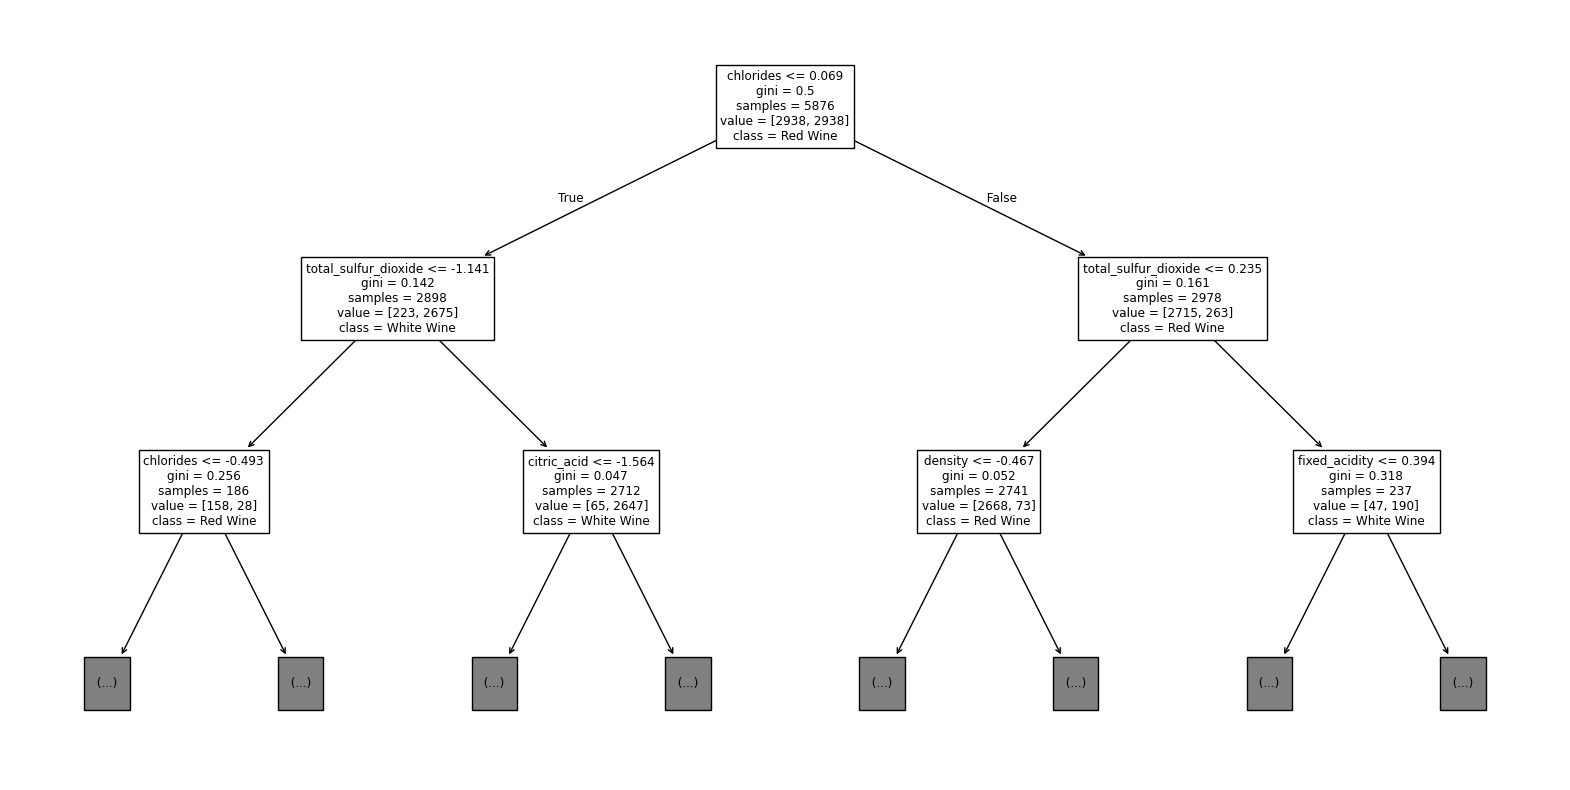

Validation Report for Decision Tree:

               precision    recall  f1-score   support

    Red Wine      0.979     0.963     0.971       240
  White Wine      0.988     0.993     0.991       735

    accuracy                          0.986       975
   macro avg      0.983     0.978     0.981       975
weighted avg      0.986     0.986     0.986       975



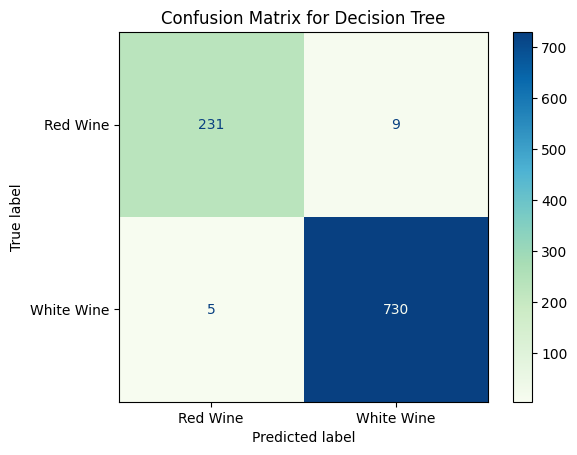

In [14]:
from sklearn.tree import DecisionTreeClassifier,plot_tree

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_resampled, y_train_resampled)

plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X.columns, class_names=['Red Wine', 'White Wine'],  max_depth=2)

plt.axis('off')
plt.show()

show_report("Decision Tree", dt_model, X_val_scaled, y_val)

## Nasumična šuma

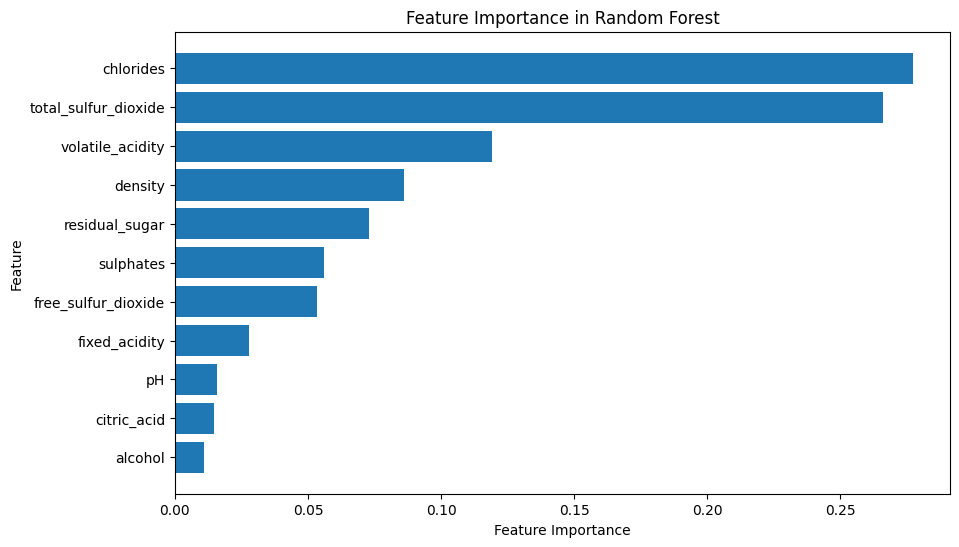

Validation Report for Random Forest:

               precision    recall  f1-score   support

    Red Wine      0.996     0.983     0.990       240
  White Wine      0.995     0.999     0.997       735

    accuracy                          0.995       975
   macro avg      0.995     0.991     0.993       975
weighted avg      0.995     0.995     0.995       975



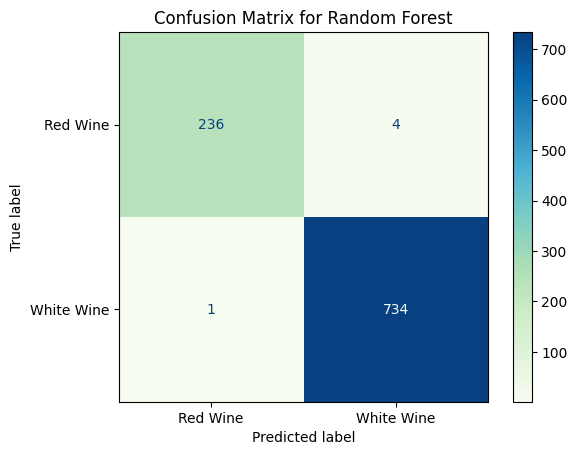

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

feature_importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()  # To have the most important feature at the top
plt.show()

show_report("Random Forest", rf_model, X_val_scaled, y_val)

# Zaključak

TBD